# Solución de problemas - Predicción de calificaciones
## Camila Johana González Acosta 599303

En esta actividad trabajamos con la base de datos de calificaciones de estudiantes.  
El objetivo es predecir la calificación final a partir de variables demográficas y académicas.

## 1. Importar los datos y mostrar tipos de variables

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

calif = pd.read_csv("A1.5 Calificaciones.csv")

# Mostramos los tipos de datos de cada variable
print(calif.dtypes)

Escuela           object
Sexo              object
Edad               int64
HorasDeEstudio     int64
Reprobadas         int64
Internet          object
Faltas             int64
G1                 int64
G2                 int64
G3                 int64
dtype: object


## 2. Transformar variables categóricas

Transformamos las variables cualitativas en variables numéricas con `pd.get_dummies`.  
Así podremos usarlas en el modelo de regresión lineal múltiple.


In [3]:
calif_mod = pd.get_dummies(calif, drop_first=True)
print(calif_mod.head())

   Edad  HorasDeEstudio  Reprobadas  Faltas  G1  G2  G3  Escuela_MS  Sexo_M  \
0    18               2           0       6   5   6   6       False   False   
1    17               2           0       4   5   5   6       False   False   
2    15               2           3      10   7   8  10       False   False   
3    15               3           0       2  15  14  15       False   False   
4    16               2           0       4   6  10  10       False   False   

   Internet_yes  
0         False  
1          True  
2          True  
3          True  
4         False  


## 3. Identificar valores atípicos en Faltas con el método de Tukey (k=3)

Se calculan los límites inferior y superior y se detectan los outliers.  
Después se eliminan para no afectar al modelo.

In [4]:
q1 = calif_mod['Faltas'].quantile(0.25)
q3 = calif_mod['Faltas'].quantile(0.75)
iqr = q3 - q1

lim_inf = q1 - 3*iqr
lim_sup = q3 + 3*iqr

outliers = calif_mod[(calif_mod['Faltas'] < lim_inf) | (calif_mod['Faltas'] > lim_sup)]
print("Valores atípicos en Faltas:")
print(outliers)

# Eliminamos outliers
calif_mod = calif_mod[(calif_mod['Faltas'] >= lim_inf) & (calif_mod['Faltas'] <= lim_sup)]


Valores atípicos en Faltas:
     Edad  HorasDeEstudio  Reprobadas  Faltas  G1  G2  G3  Escuela_MS  Sexo_M  \
74     16               2           0      54  11  12  11       False   False   
183    17               2           0      56   9   9   8       False   False   
276    18               2           0      75  10   9   9       False   False   
307    19               1           1      38   8   9   8       False    True   
315    19               3           1      40  13  11  11       False   False   

     Internet_yes  
74           True  
183          True  
276          True  
307          True  
315          True  


## 4. Matriz de correlaciones y heatmap

Se calcula la matriz de correlación para revisar posibles problemas de colinealidad.  
Luego se muestra un mapa de calor sencillo.

                    Edad  HorasDeEstudio  Reprobadas    Faltas        G1  \
Edad            1.000000       -0.003722    0.239359  0.165289 -0.062587   
HorasDeEstudio -0.003722        1.000000   -0.174636 -0.083602  0.156821   
Reprobadas      0.239359       -0.174636    1.000000  0.095153 -0.356805   
Faltas          0.165289       -0.083602    0.095153  1.000000 -0.019258   
G1             -0.062587        0.156821   -0.356805 -0.019258  1.000000   
G2             -0.141346        0.134785   -0.357020 -0.021735  0.852483   
G3             -0.160187        0.096151   -0.361642  0.071524  0.801391   
Escuela_MS      0.385884       -0.091285    0.060437 -0.084612 -0.026802   
Sexo_M         -0.027746       -0.303429    0.041325 -0.022958  0.094458   
Internet_yes   -0.118421        0.059959   -0.064223  0.094114  0.073087   

                      G2        G3  Escuela_MS    Sexo_M  Internet_yes  
Edad           -0.141346 -0.160187    0.385884 -0.027746     -0.118421  
HorasDeEstudio  0

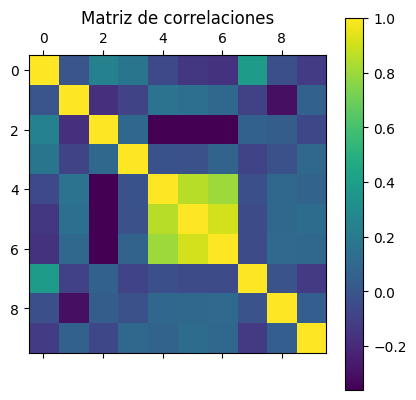

In [5]:
corr = calif_mod.corr()
print(corr)

plt.matshow(corr)
plt.title("Matriz de correlaciones")
plt.colorbar()
plt.show()

## 5. Crear términos de interacción

Agregamos interacciones entre dos pares de variables:
- `G1 * G2`
- `Edad * HorasDeEstudio`


In [6]:
calif_mod['G1_G2'] = calif_mod['G1'] * calif_mod['G2']
calif_mod['Edad_HorasEstudio'] = calif_mod['Edad'] * calif_mod['HorasDeEstudio']
print(calif_mod.head())

   Edad  HorasDeEstudio  Reprobadas  Faltas  G1  G2  G3  Escuela_MS  Sexo_M  \
0    18               2           0       6   5   6   6       False   False   
1    17               2           0       4   5   5   6       False   False   
2    15               2           3      10   7   8  10       False   False   
3    15               3           0       2  15  14  15       False   False   
4    16               2           0       4   6  10  10       False   False   

   Internet_yes  G1_G2  Edad_HorasEstudio  
0         False     30                 36  
1          True     25                 34  
2          True     56                 30  
3          True    210                 45  
4         False     60                 32  


## 6. Entrenar modelo de regresión lineal múltiple

Se divide la base en 80% entrenamiento y 20% prueba.  
El modelo se entrena con la fórmula matricial:  



Coeficientes del modelo:
Edad                -0.096482
HorasDeEstudio       0.474845
Reprobadas          -0.295996
Faltas               0.066934
G1                   0.187039
G2                    0.99258
Escuela_MS                0.0
Sexo_M               0.092423
Internet_yes        -0.322956
G1_G2               -0.003769
Edad_HorasEstudio   -0.037441
const                0.170213
dtype: object

Fórmula del modelo (como en la PPT):
G3 = -0.096*Edad + 0.475*HorasDeEstudio - 0.296*Reprobadas + 0.067*Faltas + 0.187*G1 + 0.993*G2 + 0.000*Escuela_MS + 0.092*Sexo_M - 0.323*Internet_yes - 0.004*G1_G2 - 0.037*Edad_HorasEstudio + 0.170*const


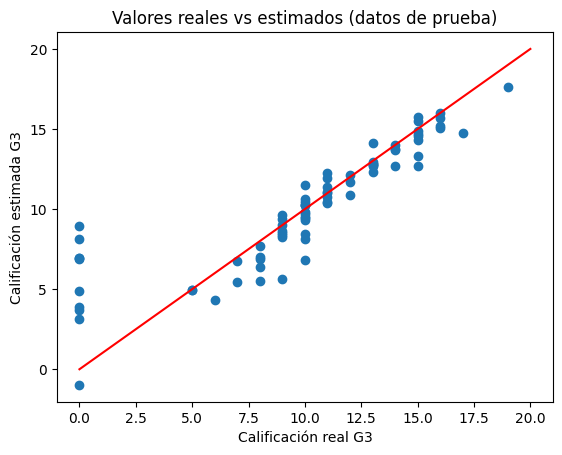

Si los puntos están cerca de la línea roja, el modelo logra buenas predicciones.


In [11]:
X = calif_mod.drop('G3', axis=1)
y = calif_mod['G3']

X = X.copy()
X['const'] = 1

# Split 80/20
n = len(X)
n_train = int(n * 0.8)
X_train = X.iloc[:n_train]
y_train = y.iloc[:n_train]
X_test = X.iloc[n_train:]
y_test = y.iloc[n_train:]

XtX = X_train.T.dot(X_train)

# pseudo-inversa en lugar de inversa
XtX_inv = pd.DataFrame(
    np.linalg.pinv(XtX.astype(float).values),
    XtX.columns,
    XtX.columns
)

XtY = X_train.T.dot(y_train)
betas = XtX_inv.dot(XtY)

print("Coeficientes del modelo:")
print(betas)

formula = "G3 = "
for i, coef in enumerate(betas):
    if i == 0:
        formula += f"{coef:.3f}*{betas.index[i]}"
    else:
        sign = "+" if coef >= 0 else "-"
        formula += f" {sign} {abs(coef):.3f}*{betas.index[i]}"
print("\nFórmula del modelo (como en la PPT):")
print(formula)


# Predicciones en datos de prueba
y_pred = X_test.dot(betas)

# Gráfica real vs estimado
plt.scatter(y_test, y_pred)
plt.xlabel("Calificación real G3")
plt.ylabel("Calificación estimada G3")
plt.title("Valores reales vs estimados (datos de prueba)")
plt.plot([0,20],[0,20], color='red')
plt.show()

print("Si los puntos están cerca de la línea roja, el modelo logra buenas predicciones.")


Conclusión: El modelo logra capturar bastante bien la relación entre las variables y la calificación final (G3). La mayoría de los puntos se concentran cerca de la diagonal roja, lo que indica que las predicciones son razonablemente acertadas, especialmente para calificaciones medias y altas. Sin embargo, se observan errores mayores en el rango de calificaciones muy bajas.